In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import requests

In [ ]:
df_with_counties = pd.from_csv('/content/drive/My Drive/WildFire/Final/modis_2019_United_States.csv')

# Extracting the counties based on latitudes and longitudes

from timeit import timeit

df['state'] = ""
df['county'] = ""

start = timeit()
for i in range(len(df)):
  results = reverse_geocoder.search((df['latitude'][i], df['longitude'][i]))
  df['state'][i] = results[0]['admin1']
  df['county'][i] = results[0]['admin2']
  print(i, "     :     ", state, "    ", county)
  # print(df.head())

end = timeit()

print(end-start)

df_with_counties = pd.to_csv('/content/drive/My Drive/WildFire/Final/modis_2019_loc.csv')

In [ ]:
df = pd.read_csv('/content/drive/My Drive/WildFire/Final/modis_2019_loc_new.csv')

FileNotFoundError: ignored

In [ ]:
%load_ext google.colab.data_table
df.drop(df.columns[0], axis = 1, inplace=True)


def normalize(df, feature_name):
    max_value = df[feature_name].max()
    min_value = df[feature_name].min()
    print(max_value, min_value)
    for i in range(len(df[feature_name])):
        df[feature_name][i] = (df[feature_name][i] - min_value) / (max_value - min_value) * 100

normalize(df, 'Wildfire_Intensity')

df

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


KeyError: ignored

In [ ]:
df_Cal = df[df.States =='California']

AttributeError: ignored

# **EDA** #

Link to variable description : https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/c6-mcd14dl

In [ ]:
df_Cal.describe()

,latitude,longitude,brightness,scan,track,acq_time,confidence,version,Wildfire_Intensity,frp,type
count,5865.000000,5865.000000,5865.000000,5865.000000,5865.000000,5865.000000,5865.000000,5.865000e+03,5865.000000,5865.000000,5865.000000
mean,38.158979,-120.671265,327.334851,1.591816,1.207349,1696.531117,70.067349,6.030000e+00,22.998758,82.975396,0.103495
std,2.054372,1.641167,25.652963,0.765344,0.238977,553.702231,22.657597,4.920928e-13,7.964517,279.946468,0.443649
min,32.694900,-124.332400,300.000000,1.000000,1.000000,511.000000,0.000000,6.030000e+00,1.406366,2.100000,0.000000
25%,36.631400,-122.008600,310.800000,1.100000,1.000000,1820.000000,55.000000,6.030000e+00,17.764619,12.000000,0.000000
50%,38.695500,-120.647200,321.300000,1.200000,1.100000,1914.000000,72.000000,6.030000e+00,22.131754,23.600000,0.000000
75%,39.981400,-119.507600,334.400000,1.900000,1.300000,2106.000000,89.000000,6.030000e+00,28.275352,55.600000,0.000000
max,42.140800,-114.349700,504.500000,4.800000,2.000000,2214.000000,100.000000,6.030000e+00,100.000000,5601.500000,3.000000


In [ ]:
df_Cal.describe(include = 'object')

,acq_date,satellite,instrument,daynight,Cities,States,Counties
count,5865,5865,5865,5865,5865,5865,5865
unique,307,2,1,2,418,1,54
top,2019-09-08,Terra,MODIS,D,Janesville,California,Lassen County
freq,276,3042,5865,4476,472,5865,512


In [ ]:
!pip install pandas-profiling

In [ ]:
!pip install pandas==0.25

In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df_Cal)
profile

/usr/local/lib/python3.7/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,19
Number of observations,5865
Total Missing (%),0.0%
Total size in memory,870.7 KiB
Average record size in memory,152.0 B
Numeric,10
Categorical,5
Boolean,0
Date,0
Text (Unique),0
Rejected,4


## Places with live fire

In [ ]:
import folium

center_lat = 35.26
center_lon = -119.5072

locationmap = folium.Map(location=[ center_lat , center_lon ], zoom_start=11, width=800, height=600 )
longitud  = len( df_Cal )

for i in range ( longitud ):
    lng = float(df_Cal.iloc[i]['longitude'])
    lat = float(df_Cal.iloc[i]['latitude'])
    description = 'Cities: ' + str(df_Cal.iloc[i]['Cities']) + '<br> Counties: ' + str(df_Cal.iloc[i]['Counties'])
    folium.Marker( [ lat , lng ],
                 popup= description,
                 icon=folium.Icon(color='red')).add_to(locationmap)

KeyboardInterrupt: ignored

In [ ]:
locationmap

## Weather API

In [ ]:
import requests

df_With_Weather = df_Cal.copy()

df_With_Weather['precipitation'] = ""
df_With_Weather['min_tmp'] = 0.0
df_With_Weather['max_tmp'] = 0.0
df_With_Weather['wind_speed'] = 0.0
df_With_Weather['humidity'] = 0
df_With_Weather['air_pressure'] = 0.0

NameError: ignored

In [ ]:
df_With_Weather.reset_index(inplace=True)

df_With_Weather

,index,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,Cities,States,Counties,precipitation,min_tmp,max_tmp,wind_speed,humidity,air_pressure
0,7,34.0070,-117.3790,304.5,1.1,1.1,2019-01-01,2053,Aqua,MODIS,59,6.03,288.6,6.5,D,2,Rubidoux,California,Riverside County,,0.0,0.0,0.0,0,0.0
1,32,37.4482,-121.4345,306.8,1.5,1.2,2019-01-02,2137,Aqua,MODIS,64,6.03,287.0,15.8,D,0,Tracy,California,San Joaquin County,,0.0,0.0,0.0,0,0.0
2,33,37.7627,-120.9014,307.2,1.6,1.3,2019-01-02,2137,Aqua,MODIS,65,6.03,286.4,17.6,D,0,Riverbank,California,Stanislaus County,,0.0,0.0,0.0,0,0.0
3,34,38.7975,-122.1700,300.3,1.4,1.2,2019-01-02,2137,Aqua,MODIS,33,6.03,287.3,7.7,D,0,Esparto,California,Yolo County,,0.0,0.0,0.0,0,0.0
4,35,39.2106,-121.6701,305.0,1.5,1.2,2019-01-02,2137,Aqua,MODIS,60,6.03,285.1,14.4,D,0,Tierra Buena,California,Sutter County,,0.0,0.0,0.0,0,0.0
5,36,39.2267,-122.2218,331.3,1.4,1.2,2019-01-02,2137,Aqua,MODIS,87,6.03,288.6,52.6,D,0,Maxwell,California,Colusa County,,0.0,0.0,0.0,0,0.0
6,37,39.2693,-122.2289,308.8,1.4,1.2,2019-01-02,2137,Aqua,MODIS,68,6.03,287.9,15.2,D,0,Maxwell,California,Colusa County,,0.0,0.0,0.0,0,0.0
7,38,39.2676,-122.2455,310.8,1.4,1.2,2019-01-02,2137,Aqua,MODIS,70,6.03,288.4,17.6,D,0,Maxwell,California,Colusa County,,0.0,0.0,0.0,0,0.0
8,39,39.3795,-122.0292,327.1,1.5,1.2,2019-01-02,2137,Aqua,MODIS,85,6.03,286.6,47.1,D,0,Colusa,California,Colusa County,,0.0,0.0,0.0,0,0.0
9,40,39.3778,-122.0463,323.3,1.5,1.2,2019-01-02,2137,Aqua,MODIS,82,6.03,287.6,40.0,D,0,Colusa,California,Colusa County,,0.0,0.0,0.0,0,0.0


In [ ]:
state_abbr = {'c' : 0, 'lc': 1, 'hc': 1, 's': 2, 'hr': 2, 'lr': 2, 't': 2}

def fill_Weather(county_name, county_woeid):
  for i in range(len(df_With_Weather['Counties'])):
    if df_With_Weather['Counties'][i] == county_name:
      date = df_With_Weather['acq_date'][i].replace('-', '/')
      url = f"https://www.metaweather.com/api/location/{county_woeid}/{date}/"

      min_t = 999
      max_t = -1
      air_p = []
      hum = []
      win_s = []
      wea_abbr = 0

      try:
        response = requests.get(url)
      except requests.exceptions.HTTPError as e:
        return "Error: " + str(e) #TODO

      res = response.json()
      for j in range(len(res)):
        # Check if keys exist
        if 'air_pressure' in res[j] and res[j]['air_pressure']:
          air_p.append(res[j]['air_pressure'])

        if 'humidity' in res[j] and res[j]['humidity']:
          hum.append(res[j]['humidity'])

        if 'wind_speed' in res[j] and res[j]['wind_speed']:
          win_s.append(res[j]['wind_speed'])

        if 'max_temp' in res[j] and res[j]['max_temp']:
          max_t = max(max_t, res[j]['max_temp'])

        if 'min_temp' in res[j] and res[j]['min_temp']:
          min_t = min(min_t, res[j]['min_temp'])

        if 'weather_state_abbr' in res[j] and res[j]['weather_state_abbr']:
          wea_abbr = state_abbr[res[j]['weather_state_abbr']]
          
      df_With_Weather["precipitation"][i] = wea_abbr
      df_With_Weather["min_tmp"][i] = min_t
      df_With_Weather["max_tmp"][i] = max_t
      df_With_Weather["wind_speed"][i] = sum(win_s)/len(win_s)
      df_With_Weather["air_pressure"][i] = sum(air_p)/len(air_p)
      df_With_Weather["humidity"][i] = sum(hum)/len(hum)


fill_Weather(<county_name>, <Woeid>)
# fill_Weather('Fresno County', 2407517)

In [ ]:
df_With_Weather.describe()

In [ ]:
df_new = pd.read_csv('/content/drive/My Drive/WildFire/Final/backup3_with_weather.csv')
df_new

,Unnamed: 0,index,latitude,longitude,scan,track,acq_date,acq_time,satellite,instrument,version,Wildfire_Intensity,frp,daynight,type,Cities,States,Counties,precipitation,min_tmp,max_tmp,wind_speed,humidity,air_pressure
0,0,7,34.0070,-117.3790,1.1,1.1,2019-01-01,2053,Aqua,MODIS,6.03,288.6,6.5,D,2,Rubidoux,California,Riverside County,NaN,0.0,0.0,0.0,0,0.0
1,1,32,37.4482,-121.4345,1.5,1.2,2019-01-02,2137,Aqua,MODIS,6.03,287.0,15.8,D,0,Tracy,California,San Joaquin County,NaN,0.0,0.0,0.0,0,0.0
2,2,33,37.7627,-120.9014,1.6,1.3,2019-01-02,2137,Aqua,MODIS,6.03,286.4,17.6,D,0,Riverbank,California,Stanislaus County,NaN,0.0,0.0,0.0,0,0.0
3,3,34,38.7975,-122.1700,1.4,1.2,2019-01-02,2137,Aqua,MODIS,6.03,287.3,7.7,D,0,Esparto,California,Yolo County,NaN,0.0,0.0,0.0,0,0.0
4,4,35,39.2106,-121.6701,1.5,1.2,2019-01-02,2137,Aqua,MODIS,6.03,285.1,14.4,D,0,Tierra Buena,California,Sutter County,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860,5860,107090,38.4033,-120.9534,1.0,1.0,2019-12-30,1856,Terra,MODIS,6.03,278.8,6.4,D,0,Ione,California,Amador County,NaN,0.0,0.0,0.0,0,0.0
5861,5861,107092,40.7713,-122.6421,1.2,1.1,2019-12-30,1856,Terra,MODIS,6.03,282.5,13.0,D,0,Lewiston,California,Trinity County,NaN,0.0,0.0,0.0,0,0.0
5862,5862,107209,38.2008,-120.5822,1.1,1.0,2019-12-31,2118,Aqua,MODIS,6.03,283.2,8.2,D,0,Mountain Ranch,California,Calaveras County,NaN,0.0,0.0,0.0,0,0.0
5863,5863,107211,40.5065,-123.7505,1.0,1.0,2019-12-31,2119,Aqua,MODIS,6.03,283.2,7.5,D,0,Hydesville,California,Humboldt County,NaN,0.0,0.0,0.0,0,0.0


In [ ]:
df_new.dropna(axis=0, inplace=True)
df_new.drop(columns= ['Unnamed: 0', 'index', 'latitude', 'longitude', 'Cities', 'acq_time','scan', 'frp', 'track', 'satellite', 'instrument', 'version', 'type', 'States'], inplace=True)
df_new.reset_index(inplace=True)

df_new.rename(columns={'bright_t31': 'Wildfire_Intensity'}, inplace=True)

def normalize(df_new, feature_name):
    max_value = df_new[feature_name].max()
    min_value = df_new[feature_name].min()
    print(max_value, min_value)
    for i in range(len(df_new[feature_name])):
        df_new[feature_name][i] = (df_new[feature_name][i] - min_value) / (max_value - min_value) * 100

normalize(df_new, 'Wildfire_Intensity')
df_new

NameError: ignored

In [ ]:
profile_new = ProfileReport(df_new)

profile_new

NameError: ignored

In [ ]:
df_new.drop(columns= ['index'], inplace=True)

In [ ]:
df_new

,acq_date,Wildfire_Intensity,daynight,Counties,precipitation,min_tmp,max_tmp,wind_speed,humidity,air_pressure
0,2019-01-07,16.692427,D,Fresno County,1.0,2.293333,16.780000,3.867090,75,1021.517042
1,2019-01-07,15.765070,D,Fresno County,1.0,2.293333,16.780000,3.867090,75,1021.517042
2,2019-01-07,17.774343,D,Fresno County,1.0,2.293333,16.780000,3.867090,75,1021.517042
3,2019-01-09,23.338485,N,Fresno County,1.0,2.415000,16.086667,2.910353,77,1021.138662
4,2019-01-10,31.066461,D,Fresno County,2.0,4.820000,16.646667,1.914209,77,1021.455915
5,2019-01-10,30.911901,D,Fresno County,2.0,4.820000,16.646667,1.914209,77,1021.455915
6,2019-01-10,32.148377,D,Fresno County,2.0,4.820000,16.646667,1.914209,77,1021.455915
7,2019-01-10,32.612056,D,Fresno County,2.0,4.820000,16.646667,1.914209,77,1021.455915
8,2019-01-10,32.457496,D,Fresno County,2.0,4.820000,16.646667,1.914209,77,1021.455915
9,2019-01-12,29.057187,D,Fresno County,1.0,3.480000,16.103333,2.708740,71,1018.346197


# Feature Engineering

In [ ]:
df_new.isna().sum()

acq_date              0
Wildfire_Intensity    0
daynight              0
Counties              0
precipitation         0
min_tmp               0
max_tmp               0
wind_speed            0
humidity              0
air_pressure          0
dtype: int64

In [ ]:
df_new.describe()

,Wildfire_Intensity,precipitation,min_tmp,max_tmp,wind_speed,humidity,air_pressure
count,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000
mean,45.382064,0.355401,9.799620,27.955915,3.432557,40.162021,1014.165853
std,14.083446,0.627327,5.636738,7.000128,1.242026,19.794579,4.877065
min,0.000000,0.000000,-2.800000,11.430000,1.375130,12.000000,988.620634
25%,34.003091,0.000000,4.785000,21.700000,2.648271,20.000000,1012.520833
50%,46.831530,0.000000,10.670000,29.220000,3.447703,35.000000,1014.347254
75%,56.259660,1.000000,15.040000,32.410000,3.912243,58.000000,1016.046461
max,100.000000,2.000000,20.010000,43.780000,10.089164,79.000000,1026.980282


In [ ]:
df_new.describe(include = 'object')

,acq_date,daynight,Counties
count,574,574,574
unique,137,2,5
top,2019-10-11,D,Fresno County
freq,65,500,344


In [ ]:
for i in range(len(df_new)):
  df_new['acq_date'][i] = int(df_new['acq_date'][i].split('-')[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_new.head()

,acq_date,Wildfire_Intensity,daynight,Counties,precipitation,min_tmp,max_tmp,wind_speed,humidity,air_pressure
0,1,16.692427,D,Fresno County,1.0,2.293333,16.780000,3.867090,75,1021.517042
1,1,15.765070,D,Fresno County,1.0,2.293333,16.780000,3.867090,75,1021.517042
2,1,17.774343,D,Fresno County,1.0,2.293333,16.780000,3.867090,75,1021.517042
3,1,23.338485,N,Fresno County,1.0,2.415000,16.086667,2.910353,77,1021.138662
4,1,31.066461,D,Fresno County,2.0,4.820000,16.646667,1.914209,77,1021.455915


In [ ]:
df_new["daynight"] = df_new["daynight"].astype('category')
df_new["Counties"] = df_new["Counties"].astype('category')

df_new = pd.get_dummies(df_new, drop_first = True)
df_new.head()

,Wildfire_Intensity,precipitation,min_tmp,max_tmp,wind_speed,humidity,air_pressure,acq_date_2,acq_date_3,acq_date_4,acq_date_5,acq_date_6,acq_date_7,acq_date_8,acq_date_9,acq_date_10,acq_date_11,acq_date_12,daynight_N,Counties_Fresno County,Counties_Los Angeles County,Counties_Sacramento County,Counties_San Diego County
0,16.692427,1.0,2.293333,16.780000,3.867090,75,1021.517042,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,15.765070,1.0,2.293333,16.780000,3.867090,75,1021.517042,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,17.774343,1.0,2.293333,16.780000,3.867090,75,1021.517042,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,23.338485,1.0,2.415000,16.086667,2.910353,77,1021.138662,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
4,31.066461,2.0,4.820000,16.646667,1.914209,77,1021.455915,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
profile_new_n = ProfileReport(df_new)

profile_new_n

/usr/local/lib/python3.7/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,23
Number of observations,574
Total Missing (%),0.0%
Total size in memory,40.5 KiB
Average record size in memory,72.2 B
Numeric,7
Categorical,0
Boolean,16
Date,0
Text (Unique),0
Rejected,0


# Feature Modeling

In [ ]:
X = df_new.drop('Wildfire_Intensity', axis = 1)
y = df_new['Wildfire_Intensity']

In [ ]:
X.head()

,precipitation,min_tmp,max_tmp,wind_speed,humidity,air_pressure,acq_date_2,acq_date_3,acq_date_4,acq_date_5,acq_date_6,acq_date_7,acq_date_8,acq_date_9,acq_date_10,acq_date_11,acq_date_12,daynight_N,Counties_Fresno County,Counties_Los Angeles County,Counties_Sacramento County,Counties_San Diego County
0,1.0,2.293333,16.780000,3.867090,75,1021.517042,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1.0,2.293333,16.780000,3.867090,75,1021.517042,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1.0,2.293333,16.780000,3.867090,75,1021.517042,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1.0,2.415000,16.086667,2.910353,77,1021.138662,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
4,2.0,4.820000,16.646667,1.914209,77,1021.455915,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
y.head()

0    16.692427
1    15.765070
2    17.774343
3    23.338485
4    31.066461
Name: Wildfire_Intensity, dtype: float64

In [ ]:
from  sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
len(x_train), len(x_validation), len(y_train), len(y_validation)

(459, 115, 459, 115)

In [ ]:
# Importing sklearn methods
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

In [ ]:
# A class that will define all the regression models as methods

class Models(object):
    
    global seed 
    seed = 34234
    
    # Initialization 
    def __init__(self, x_train, x_validation, y_train, y_validation):
        # changing input as dataframe to list
        self.x_train = [x_train.iloc[i].tolist() for i in range(len(x_train))]
        self.x_validation = [x_validation.iloc[i].tolist() for i in range(len(x_validation))]
        self.y_train = y_train.tolist()
        self.y_validation = y_validation.tolist()
    
    
    @staticmethod
    def print_info(cross_val_scores, mse):
        print("Cross Validation Scores: ", cross_val_scores)
        print("Mean Squared Error: ", mse)
        print(cross_val_scores.mean())
        
        
    # Linear Regression 
    def linear_regression(self, x_train, x_validation,  y_train, y_validation):
        reg = linear_model.LinearRegression()
        # X = np.array(X).reshape([-1, 1])
        reg.fit(self.x_train, self.y_train)
        y_pred_list = reg.predict(self.x_validation)
        mse = mean_squared_error(self.y_validation, y_pred_list)
        kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
        cross_val_scores = cross_val_score(reg, self.x_train, self.y_train, cv=kfold)
        print("\nLinear Regression Model")
        self.print_info(cross_val_scores, mse)
        return cross_val_scores, mse
        
    # Random Forest Regression model 
    def random_forest(self, x_train, x_validation,  y_train, y_validation):
        rfr = RandomForestRegressor(n_estimators=13, max_depth=9, random_state=12, verbose=0)
        # X = np.array(X).reshape([-1, 1])
        rfr.fit(self.x_train, self.y_train)
        y_pred_list = rfr.predict(self.x_validation)
        mse = mean_squared_error(self.y_validation, y_pred_list)
        kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
        cross_val_scores = cross_val_score(rfr, self.x_train, self.y_train, cv=kfold)
        print("\nRandom Forest Regressor")
        self.print_info(cross_val_scores, mse)
        return cross_val_scores, mse
            
    
    # Gradient Boosing Regressor
    def GBR(self, x_train, x_validation,  y_train, y_validation):
        gbr = GradientBoostingRegressor(n_estimators=175, learning_rate=0.08, max_depth=3, random_state=1232, loss='ls')
        gbr.fit(self.x_train, self.y_train)
        kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
        cross_val_scores = cross_val_score(gbr, self.x_train, self.y_train, cv=kfold)
        mse = mean_squared_error(self.y_validation, gbr.predict(self.x_validation))
        print('\nGradient Boosting Regressor')
        self.print_info(cross_val_scores, mse)
        return cross_val_scores, mse

# Hyperparameter Tuning

In [ ]:
# We use GridSearchCV to find out the best set of parameters for GBR and use it for the 
# regression model analysis and prediction
parameters = {
    'n_estimators' : [170, 175, 180],
    'learning_rate' : [0.075, 0.08, 0.1],
    'max_depth' : [2, 3, 4,8, 12]
}

gbr = GradientBoostingRegressor(n_estimators=250, learning_rate=0.1, max_depth=5, random_state=232, loss='ls')
gs_cv = GridSearchCV(gbr, parameters).fit(x_train, y_train)
gs_cv.best_score_

0.7634308990313199

In [ ]:
gs_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 170}

In [ ]:
parameters = {
    'n_estimators' : [5 ,7, 8, 9,10, 11, 12, 13, 17],
    'max_depth' : [4,5,6,7, 8, 9, 10]
}

gbr = RandomForestRegressor(n_estimators=250,  random_state=232)
RandomForestRegressor()
gs_cv_rfr = GridSearchCV(gbr, parameters).fit(x_train, y_train)
gs_cv_rfr.best_params_

{'max_depth': 9, 'n_estimators': 13}

In [ ]:
gs_cv_rfr.best_score_

0.755048310095468

In [ ]:
from types import FunctionType

methods = [x for x, y in Models.__dict__.items() if type(y) == FunctionType]
methods.remove('__init__')
# Now calling the all regression methods
cross_scores_list, mse_list = [], []
for model in methods:
    reg = Models(x_train, x_validation, y_train, y_validation)
    cross_val_scores, mse = getattr(reg, model)(x_train, x_validation, y_train, y_validation)
    cross_scores_list.append(cross_val_scores)
    mse_list.append(mse)


Linear Regression Model
Cross Validation Scores:  [0.65995329 0.76786152 0.57806331 0.6229897  0.67038112 0.68394861
 0.85995744 0.82058815 0.67165514 0.48091488]
Mean Squared Error:  54.00709970590465
0.6816313163882302

Random Forest Regressor
Cross Validation Scores:  [0.74765115 0.79613747 0.8424279  0.78237161 0.77112974 0.82868557
 0.86004851 0.75077834 0.73759269 0.64121223]
Mean Squared Error:  50.75294690414947
0.7758035206812359

Gradient Boosting Regressor
Cross Validation Scores:  [0.75133378 0.81659376 0.83102888 0.78332265 0.78690859 0.76394492
 0.8220862  0.73592731 0.71984921 0.59633563]
Mean Squared Error:  45.726059335859105
0.7607330906013885


## Test Input

In [ ]:
rfr = RandomForestRegressor(n_estimators=13, max_depth=9, random_state=12, verbose=0)
# X = np.array(X).reshape([-1, 1])
rfr.fit(x_train, y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=13, n_jobs=None, oob_score=False,
                      random_state=12, verbose=0, warm_start=False)

In [ ]:
x_train

,precipitation,min_tmp,max_tmp,wind_speed,humidity,air_pressure,acq_date_2,acq_date_3,acq_date_4,acq_date_5,acq_date_6,acq_date_7,acq_date_8,acq_date_9,acq_date_10,acq_date_11,acq_date_12,daynight_N,Counties_Fresno County,Counties_Los Angeles County,Counties_Sacramento County,Counties_San Diego County
85,0.0,3.180,17.570000,4.550654,67,1017.582394,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
351,0.0,15.040,29.580000,3.447703,19,1014.347254,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
122,1.0,9.675,22.410000,4.846821,57,1016.927035,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
523,1.0,4.190,19.255000,3.652982,57,1005.013889,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
118,2.0,7.750,23.325000,3.088414,62,1014.212577,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
356,0.0,15.040,29.580000,3.447703,19,1014.347254,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
439,0.0,17.505,32.305000,2.901642,18,1015.057917,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
318,0.0,15.040,29.580000,3.447703,19,1014.347254,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
536,1.0,4.070,20.605000,2.884720,53,1012.520833,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
208,0.0,16.540,43.780000,3.580929,18,1011.425139,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


## Predict Valaues

In [ ]:
rfr.predict([[]])

In [ ]:
%matplotlib inline

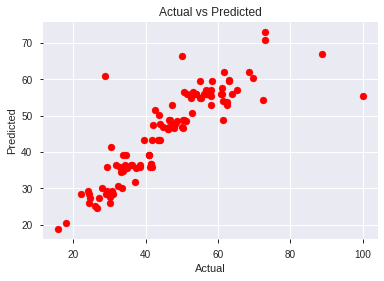

In [ ]:
import matplotlib.pyplot as plot

plot.scatter(y_validation, rfr.predict(x_validation), color = 'red')
# plot.plot(y_validation, rfr.predict(x_validation), color = 'blue')
plot.title('Actual vs Predicted')
plot.xlabel('Actual')
plot.ylabel('Predicted')
plot.show()